In [70]:
from dataset import PPMIBrainDataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [71]:
dataset = PPMIBrainDataset('../data/PPMI')
print(dataset[0])   

Data(x=[116, 116], edge_index=[2, 13456], edge_attr=[13456], y=0)


In [72]:
connectivities = [(data.x, data.y) for data in dataset]
print(len(connectivities))

209


In [73]:
control = torch.stack([connectivity[0] for connectivity in connectivities if connectivity[1] == 0])
pd = torch.stack([connectivity[0] for connectivity in connectivities if connectivity[1] == 1])
prodromal = torch.stack([connectivity[0] for connectivity in connectivities if connectivity[1] == 2])
swedd = torch.stack([connectivity[0] for connectivity in connectivities if connectivity[1] == 3])
print(control.shape, pd.shape, prodromal.shape, swedd.shape)

torch.Size([15, 116, 116]) torch.Size([113, 116, 116]) torch.Size([67, 116, 116]) torch.Size([14, 116, 116])


In [74]:
control_mean = control.mean(dim=0)
pd_mean = pd.mean(dim=0)
prodromal_mean = prodromal.mean(dim=0)
swedd_mean = swedd.mean(dim=0)
print(control_mean.shape, pd_mean.shape, prodromal_mean.shape, swedd_mean.shape)

torch.Size([116, 116]) torch.Size([116, 116]) torch.Size([116, 116]) torch.Size([116, 116])


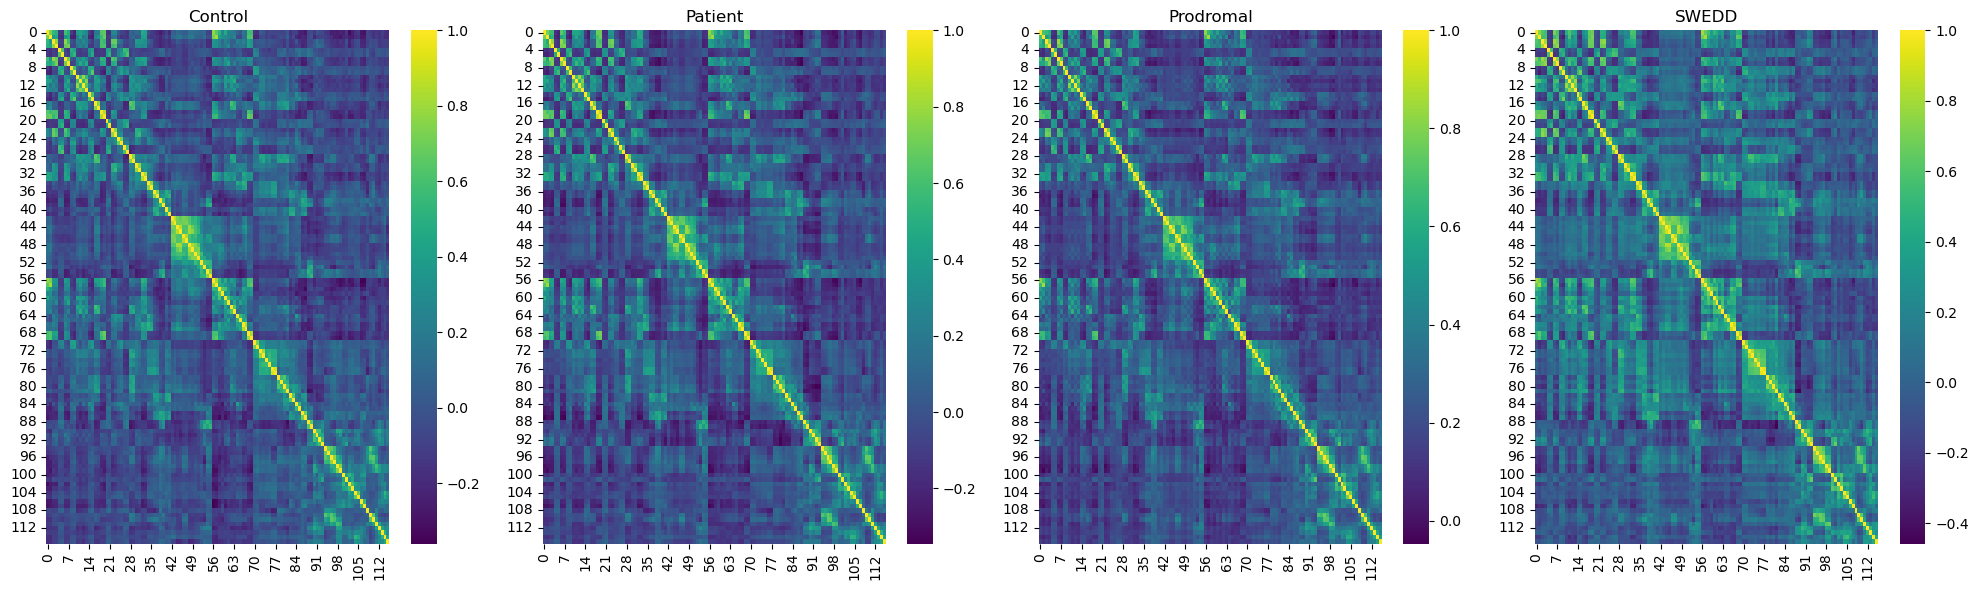

In [75]:
# Create a figure with 4 subplots arranged in 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Heatmap 1
sns.heatmap(control_mean.numpy(), ax=axs[0], cmap="viridis")
axs[0].set_title("Control")

# Heatmap 2
sns.heatmap(pd_mean.numpy(), ax=axs[1], cmap="viridis")
axs[1].set_title("Patient")

# Heatmap 3
sns.heatmap(prodromal_mean.numpy(), ax=axs[2], cmap="viridis")
axs[2].set_title("Prodromal")

# Heatmap 4
sns.heatmap(swedd_mean.numpy(), ax=axs[3], cmap="viridis")
axs[3].set_title("SWEDD")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [76]:
control_diff = torch.abs(control_mean[:, 1::2] - control_mean[:, 0::2])
pd_diff = torch.abs(pd_mean[:, 1::2] - pd_mean[:, 0::2])
prodromal_diff = torch.abs(prodromal_mean[:, 1::2] - prodromal_mean[:, 0::2])
swedd_diff = torch.abs(swedd_mean[:, 1::2] - swedd_mean[:, 0::2])
print(control_diff.shape, pd_diff.shape, prodromal_diff.shape, swedd_diff.shape)

torch.Size([116, 58]) torch.Size([116, 58]) torch.Size([116, 58]) torch.Size([116, 58])


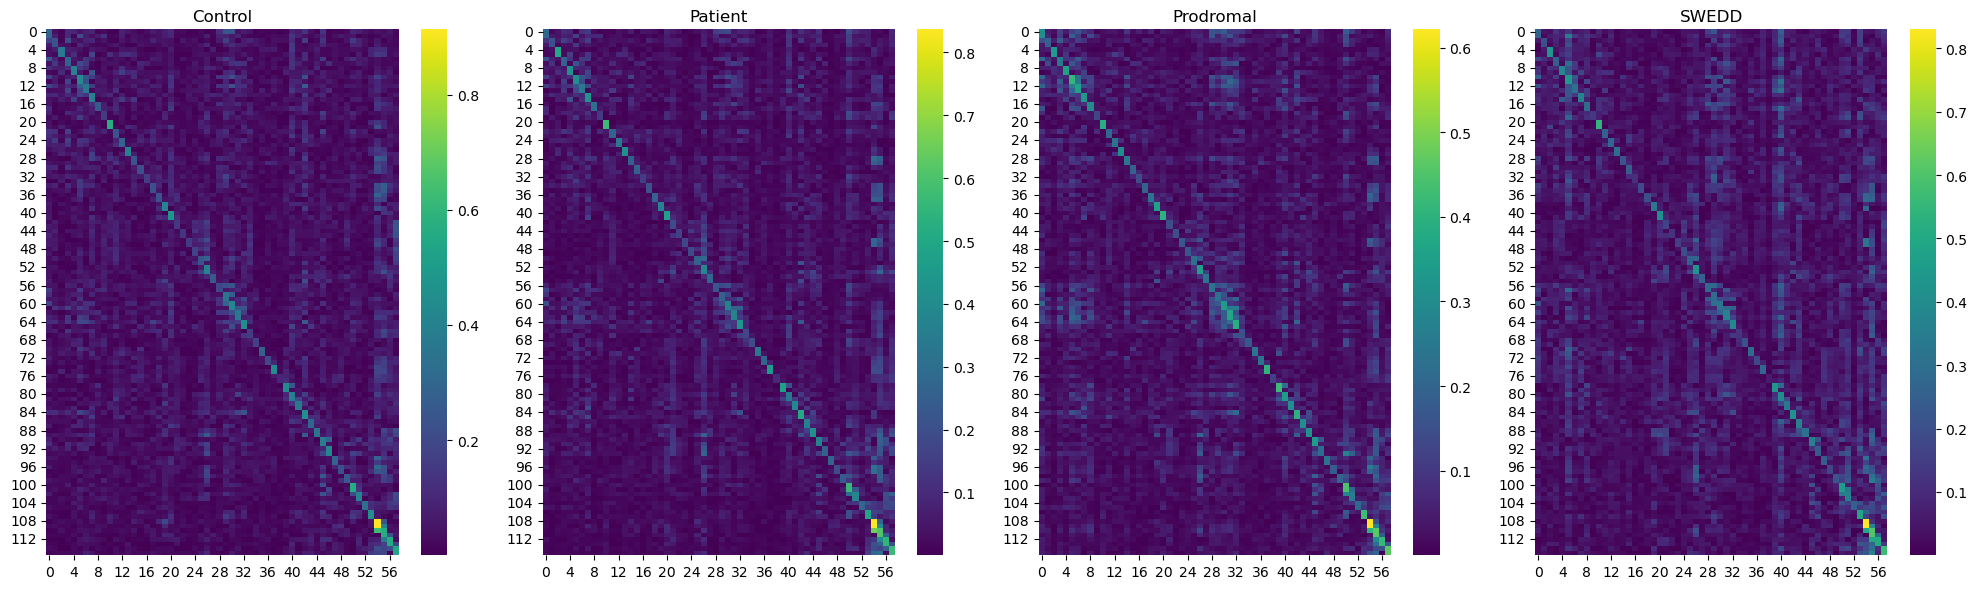

In [77]:
# Create a figure with 4 subplots arranged in 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Heatmap 1
sns.heatmap(control_diff.numpy(), ax=axs[0], cmap="viridis")
axs[0].set_title("Control")

# Heatmap 2
sns.heatmap(pd_diff.numpy(), ax=axs[1], cmap="viridis")
axs[1].set_title("Patient")

# Heatmap 3
sns.heatmap(prodromal_diff.numpy(), ax=axs[2], cmap="viridis")
axs[2].set_title("Prodromal")

# Heatmap 4
sns.heatmap(swedd_diff.numpy(), ax=axs[3], cmap="viridis")
axs[3].set_title("SWEDD")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
# Function to perform t-test between two sets of matrices
def perform_t_tests(set1, set2):
    # Calculate the means of each connectivity feature across samples
    mean1 = set1.mean(dim=0)
    mean2 = set2.mean(dim=0)
    
    # Flatten the matrices to perform t-test on each feature (element in the matrix)
    set1_flat = set1.view(set1.size(0), -1)
    set2_flat = set2.view(set2.size(0), -1)
    
    # Store p-values
    p_values = []
    
    # Perform t-test on each feature
    for i in range(set1_flat.size(1)):
        _, p_value = stats.ttest_ind(set1_flat[:, i].numpy(), set2_flat[:, i].numpy())
        p_values.append(p_value)
    
    # Reshape p-values to match the shape of the connectivity matrix
    p_values = torch.tensor(p_values).view(mean1.shape)
    
    return p_values

In [79]:
# Perform t-tests between different classes
p_values_control_pd = perform_t_tests(control, pd)
p_values_control_prodromal = perform_t_tests(control, prodromal)
p_values_control_swedd = perform_t_tests(control, swedd)

C:\Users\mosta\AppData\Local\Temp\ipykernel_28116\668697123.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_value = stats.ttest_ind(set1_flat[:, i].numpy(), set2_flat[:, i].numpy())


In [80]:
alpha = 0.05
significant_control_pd_mask = p_values_control_pd < alpha
significant_control_prodromal_mask = p_values_control_prodromal < alpha
significant_control_swedd_mask = p_values_control_swedd < alpha

In [81]:
significant_control_pd = np.where(significant_control_pd_mask.numpy(), p_values_control_pd, np.nan)
significant_control_prodromal = np.where(significant_control_prodromal_mask.numpy(), p_values_control_prodromal, np.nan)
significant_control_swedd = np.where(significant_control_swedd_mask.numpy(), p_values_control_swedd, np.nan)
print(f'Ratio of significant connections between control and PD: {torch.sum(significant_control_pd_mask)/(control.shape[1]*control.shape[2])}')
print(f'Ratio of significant connections between control and Prodromal: {torch.sum(significant_control_prodromal_mask)/(control.shape[1]*control.shape[2])}')
print(f'Ratio of significant connections between control and SWEDD: {torch.sum(significant_control_swedd_mask)/(control.shape[1]*control.shape[2])}')

Ratio of significant connections between control and PD: 0.05112960934638977
Ratio of significant connections between control and Prodromal: 0.3552318811416626
Ratio of significant connections between control and SWEDD: 0.12054102122783661


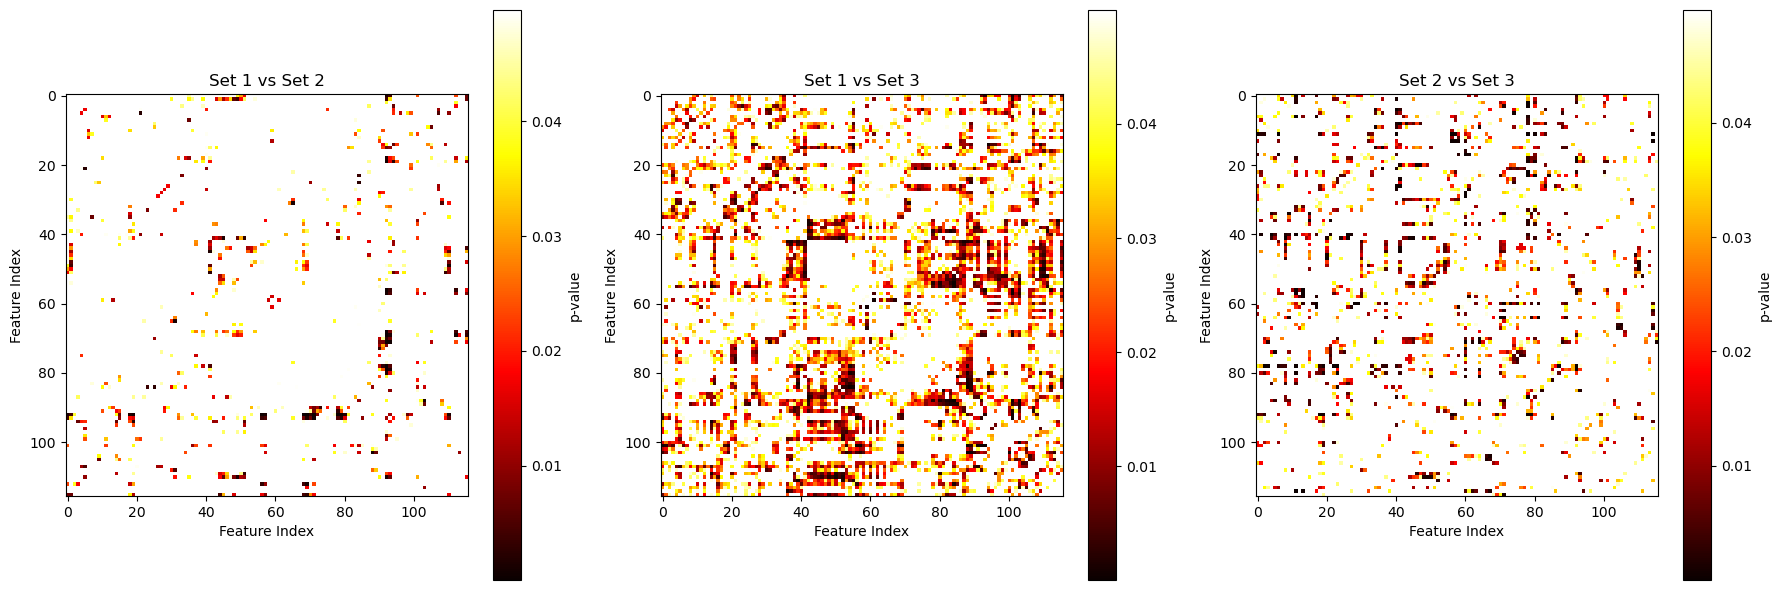

In [82]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first set of significant p-values
im1 = axes[0].imshow(significant_control_pd, cmap='hot', interpolation='nearest')
axes[0].set_title('Set 1 vs Set 2')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Feature Index')
fig.colorbar(im1, ax=axes[0], label='p-value')

# Plot the second set of significant p-values
im2 = axes[1].imshow(significant_control_prodromal, cmap='hot', interpolation='nearest')
axes[1].set_title('Set 1 vs Set 3')
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Feature Index')
fig.colorbar(im2, ax=axes[1], label='p-value')

# Plot the third set of significant p-values
im3 = axes[2].imshow(significant_control_swedd, cmap='hot', interpolation='nearest')
axes[2].set_title('Set 2 vs Set 3')
axes[2].set_xlabel('Feature Index')
axes[2].set_ylabel('Feature Index')
fig.colorbar(im3, ax=axes[2], label='p-value')

# Display the plot
plt.tight_layout()
plt.show()

In [83]:
control_asymmetry = torch.abs(control[:, :, 1::2] - control[:, :, 0::2])
pd_asymmetry = torch.abs(pd[:, :, 1::2] - pd[:, :, 0::2])
prodromal_asymmetry = torch.abs(prodromal[:, :, 1::2] - prodromal[:, :, 0::2])
swedd_asymmetry = torch.abs(swedd[:, :, 1::2] - swedd[:, :, 0::2])
print(control_asymmetry.shape, pd_asymmetry.shape, prodromal_asymmetry.shape, swedd_asymmetry.shape)

torch.Size([15, 116, 58]) torch.Size([113, 116, 58]) torch.Size([67, 116, 58]) torch.Size([14, 116, 58])


In [84]:
p_values_control_pd_asym = perform_t_tests(control_asymmetry, pd_asymmetry)
p_values_control_prodromal_asym = perform_t_tests(control_asymmetry, prodromal_asymmetry)
p_values_control_swedd_asym = perform_t_tests(control_asymmetry, swedd_asymmetry)

In [85]:
significant_control_pd_asym_mask = p_values_control_pd_asym < alpha
significant_control_prodromal_asym_mask = p_values_control_prodromal_asym < alpha
significant_control_swedd_asym_mask = p_values_control_swedd_asym < alpha

In [86]:
significant_control_pd_asym = np.where(significant_control_pd_asym_mask.numpy(), p_values_control_pd_asym, np.nan)
significant_control_prodromal_asym = np.where(significant_control_prodromal_asym_mask.numpy(), p_values_control_prodromal_asym, np.nan)
significant_control_swedd_asym = np.where(significant_control_swedd_asym_mask.numpy(), p_values_control_swedd_asym, np.nan)
print(f'Ratio of significant connections between control and PD: {torch.sum(significant_control_pd_asym_mask)/(control_asymmetry.shape[1]*control_asymmetry.shape[2])}')
print(f'Ratio of significant connections between control and Prodromal: {torch.sum(significant_control_prodromal_asym_mask)/(control_asymmetry.shape[1]*control_asymmetry.shape[2])}')
print(f'Ratio of significant connections between control and SWEDD: {torch.sum(significant_control_swedd_asym_mask)/(control_asymmetry.shape[1]*control_asymmetry.shape[2])}')

Ratio of significant connections between control and PD: 0.04577883332967758
Ratio of significant connections between control and Prodromal: 0.02630796656012535
Ratio of significant connections between control and SWEDD: 0.06316884607076645


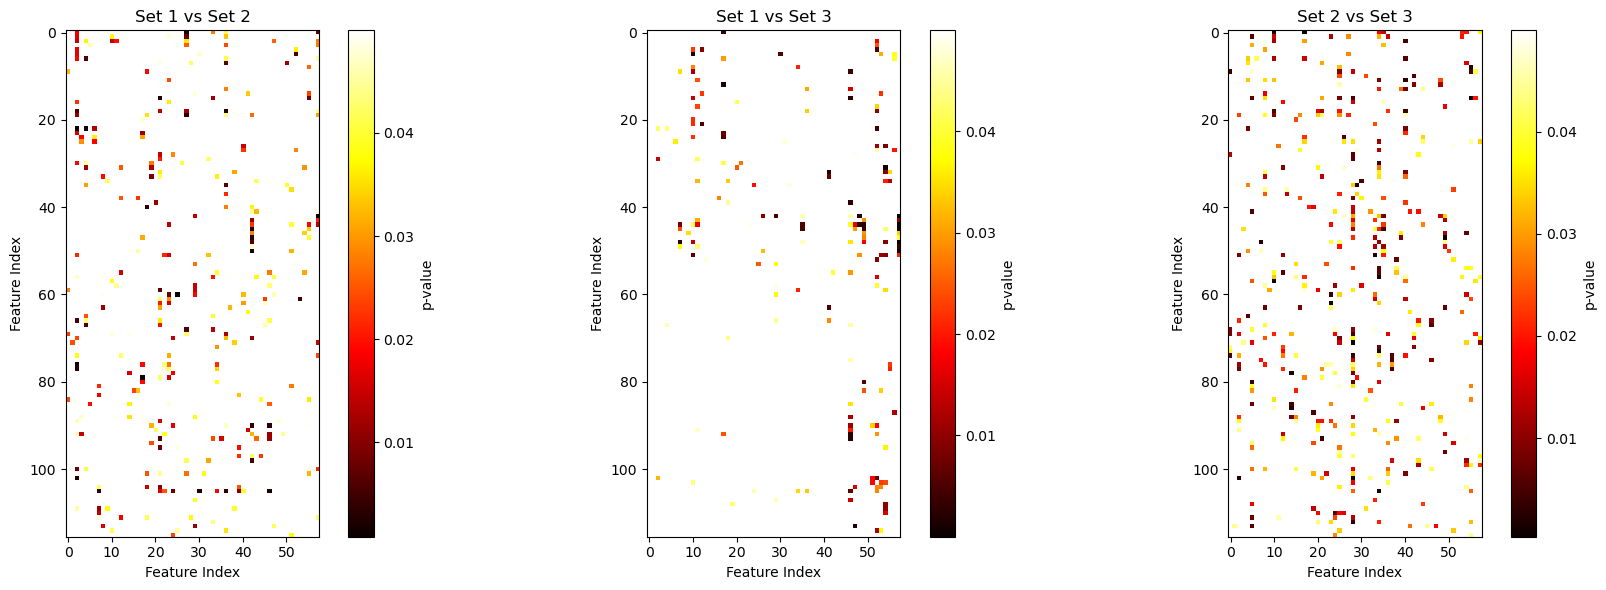

: 

In [87]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first set of significant p-values
im1 = axes[0].imshow(significant_control_pd_asym, cmap='hot', interpolation='nearest')
axes[0].set_title('Set 1 vs Set 2')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Feature Index')
fig.colorbar(im1, ax=axes[0], label='p-value')

# Plot the second set of significant p-values
im2 = axes[1].imshow(significant_control_prodromal_asym, cmap='hot', interpolation='nearest')
axes[1].set_title('Set 1 vs Set 3')
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Feature Index')
fig.colorbar(im2, ax=axes[1], label='p-value')

# Plot the third set of significant p-values
im3 = axes[2].imshow(significant_control_swedd_asym, cmap='hot', interpolation='nearest')
axes[2].set_title('Set 2 vs Set 3')
axes[2].set_xlabel('Feature Index')
axes[2].set_ylabel('Feature Index')
fig.colorbar(im3, ax=axes[2], label='p-value')

# Display the plot
plt.tight_layout()
plt.show()